In [3]:
import torch
import numpy as np

from deep_parity.model import MLPv1 as MLP, Perceptron
from deep_parity.boolean_cube import fourier_transform, get_subcube, generate_all_binary_arrays

from pathlib import Path

import torch
import polars as pl
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns


from plotnine import ggplot, qplot, aes, geom_point, geom_histogram, facet_wrap, labs

In [4]:
def make_base_parity_dataframe(n):
    all_binary_data = generate_all_binary_arrays(n).astype(np.int32)
    #all_binary_data = np.sign(-1 * all_binary_data_zero_one + 0.5)
    all_parities = all_binary_data.prod(axis=1)
    base_df = pl.DataFrame({
        'bits': all_binary_data, 
        'parities': all_parities, 
    })
    base_df = base_df.with_columns(
        indices=pl.col('bits').arr.to_list().list.eval(pl.arg_where(pl.element() == 1)),
        degree=pl.col('bits').arr.sum()
    )
    return base_df


def calc_power_contributions(tensor, n, epoch):
    linear_dim = tensor.shape[1]
    base_df = make_base_parity_dataframe(n)
    ft = fourier_transform(tensor.T)
    ft /= ft.mean(dim=0, keepdims=True)
    linear_df = pl.DataFrame(
        ft.T.detach().cpu().numpy(),
        schema=[str(i) for i in range(linear_dim)]
    )
    data = pl.concat([base_df, linear_df], how='horizontal')
    total_power = (
        data
        .select(pl.exclude('bits', 'parities', 'indices', 'degree'))
        .unpivot()
        .with_columns(pl.col('variable').str.to_integer())
        .group_by('variable').agg(pl.col('value').pow(2).sum())
        .rename({'value': 'power'})
    )
    power_df = (
        data
        .select(pl.exclude('bits', 'parities', 'indices'))
        .unpivot(index='degree')
        .with_columns(pl.col('variable').str.to_integer())
        .group_by('degree', 'variable').agg(pl.col('value').pow(2).sum())
        .join(total_power, on='variable', how='left')
        .with_columns(pcnt_power = pl.col('value') / pl.col('power'), epoch=pl.lit(epoch))
    )
    return power_df

In [6]:
checkpoint_dir = Path('checkpoints/1layer')
epoch = 10_000
model_run = torch.load(checkpoint_dir / f'{epoch}.pth', map_location='cpu', weights_only=True)
config = model_run['config']

model = Perceptron(config['n'], config['model_dim'])
model.load_state_dict(model_run['model'])

<All keys matched successfully>

In [7]:
model

Perceptron(
  (linear): Linear(in_features=18, out_features=2048, bias=True)
  (unembed): Linear(in_features=2048, out_features=2, bias=False)
)

In [8]:
boolean_cube_df = make_base_parity_dataframe(18)
boolean_cube = -1 * torch.sign(torch.from_numpy(generate_all_binary_arrays(18)).to(torch.float32) - 0.5)

In [9]:
from torch.nn.functional import relu

l1_outs = relu(model.linear(boolean_cube))
l1_ft = fourier_transform(l1_outs.T).T

In [11]:
l1_ft_df = pl.concat([boolean_cube_df, pl.DataFrame(l1_ft.detach().numpy(), schema=[str(i) for i in range(2048)])], how='horizontal')
l1_ft_df = l1_ft_df.lazy()

In [12]:
l1_acts_df = pl.concat([boolean_cube_df, pl.DataFrame(l1_outs.detach().numpy(), schema=[str(i) for i in range(2048)])], how='horizontal')



KeyboardInterrupt



In [8]:
deg1_data = (
    l1_ft_df
    .select(pl.exclude(['bits', 'parities']))
    .unpivot(index=['indices', 'degree'])
    .filter(pl.col('degree').eq(1))
    .group_by('variable')
    .agg(mean_deg1 = (pl.col('value')**2).mean(), var_deg1 = (pl.col('value')**2).std())
    .collect()
)

In [29]:
spiky_cols = deg1_data.filter(pl.col('mean_deg1').gt(50)).sort('var_deg1')['variable'].to_list()[:100]

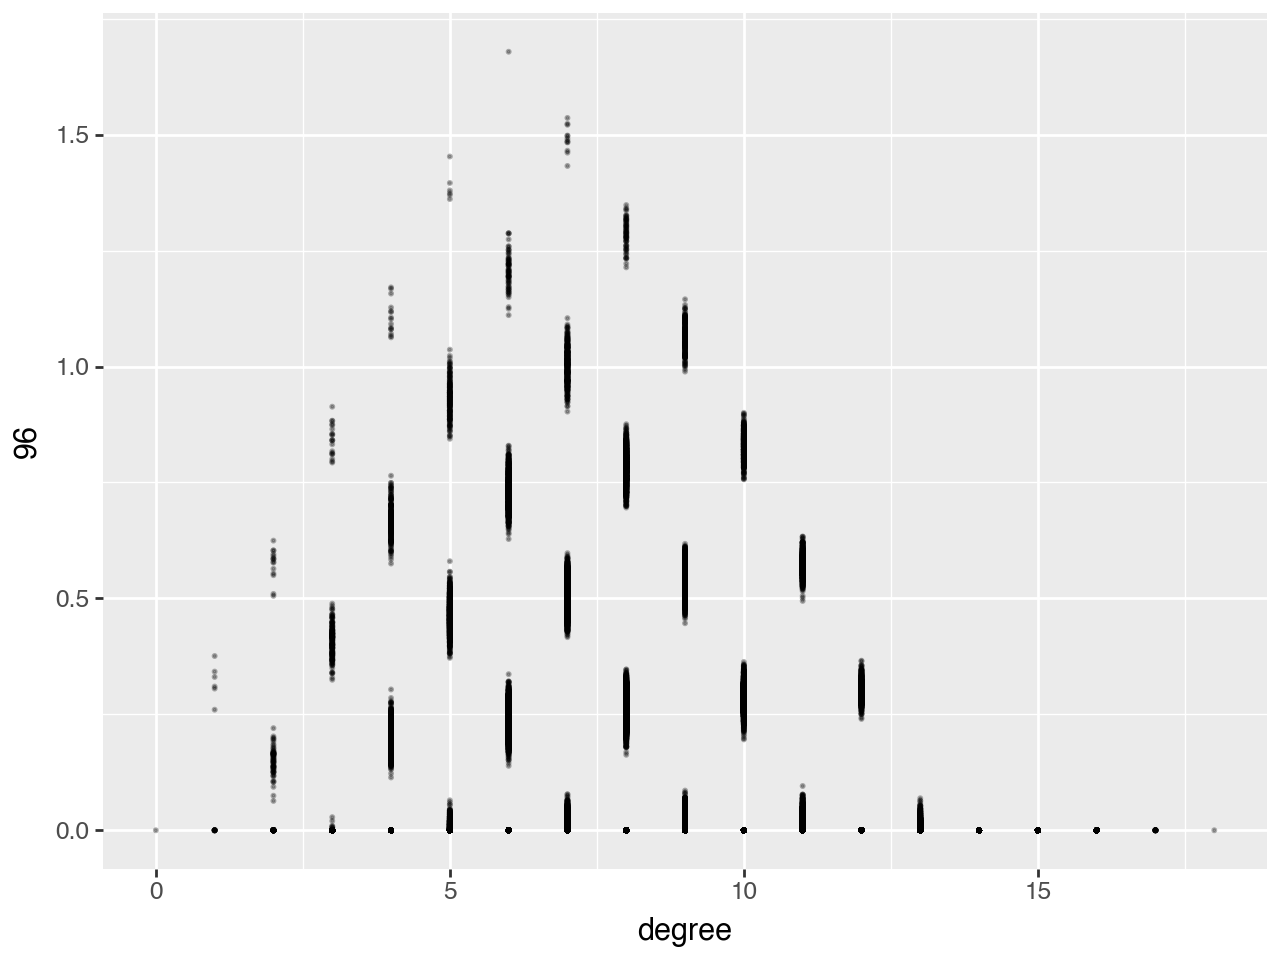

In [67]:
from random import choice
from plotnine import scale_y_log10
i = int(choice(spiky_cols))
j = int(choice(spiky_cols))
#col_idx = int(spiky_cols[-28])
#df = pl.DataFrame({f'{i}': l1_outs[:, i].numpy(), f'{j}': l1_outs[:, j].numpy(),})
ggplot(l1_acts_df, aes(x='degree', y=str(i))) + geom_point(size=0.2, alpha=0.3) 

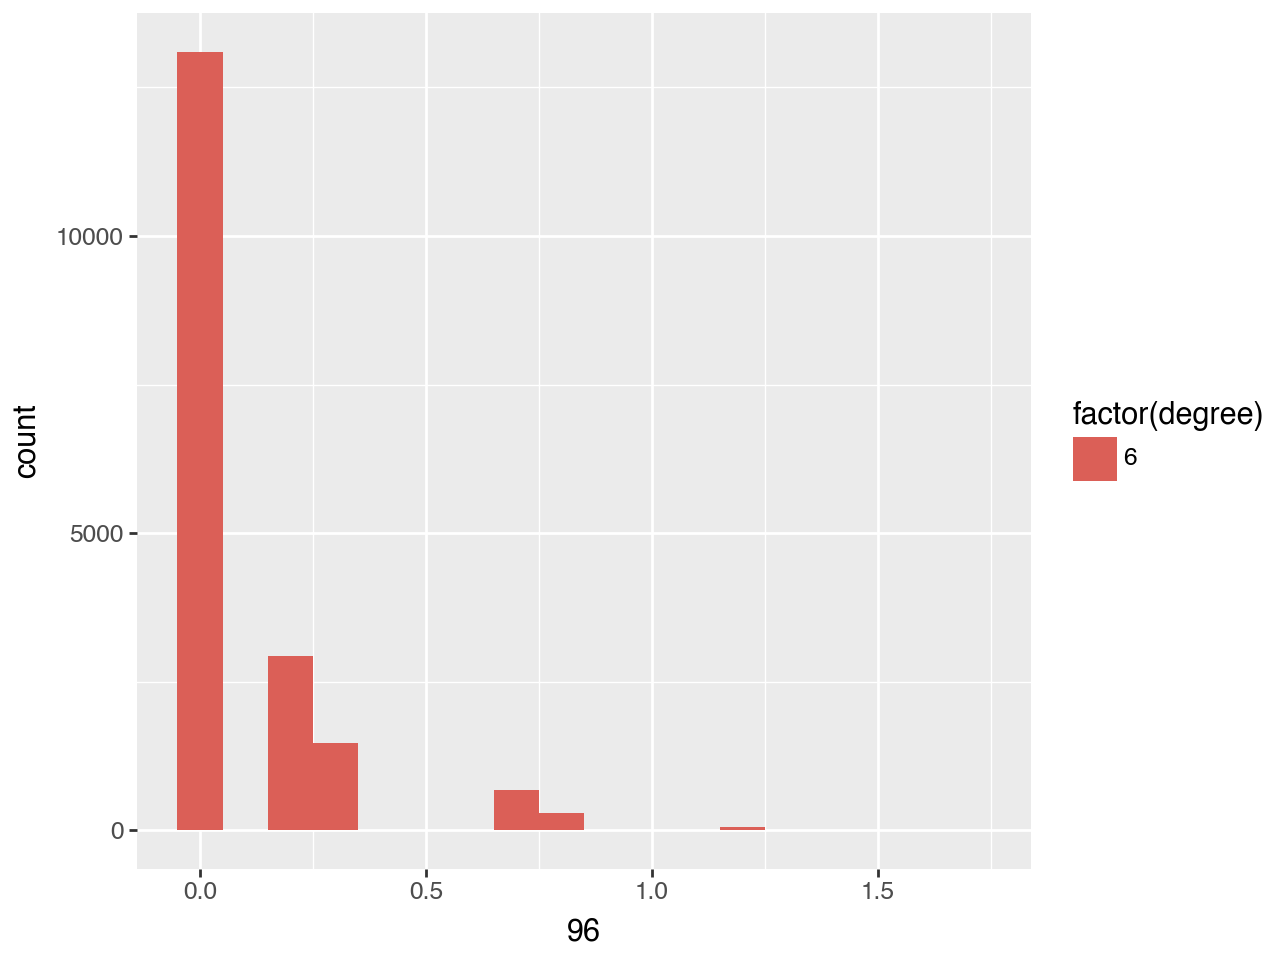

In [109]:
ggplot(l1_acts_df.filter(pl.col('degree').eq(6)), aes(x=str(i), fill='factor(degree)')) + geom_histogram(binwidth=0.1) 

In [123]:
_, temp_cache = model.run_with_cache(val)

In [157]:
l1_ft[[2**(17-i) for i in range(18)], i]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
boolean_cube

tensor([[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1., -1.],
        [ 1.,  1.,  1.,  ...,  1., -1.,  1.],
        ...,
        [-1., -1., -1.,  ..., -1.,  1., -1.],
        [-1., -1., -1.,  ..., -1., -1.,  1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])

934
tensor([  7.3396, -13.2883,  -1.3907,  -9.9866,  -2.4174,   1.9816,  -2.1769,
         -3.4337,   1.0595,  10.2910, -23.3601,   6.7411,   9.3623,  17.1901,
        -23.8028, -22.3060,   2.2297,   6.9518])


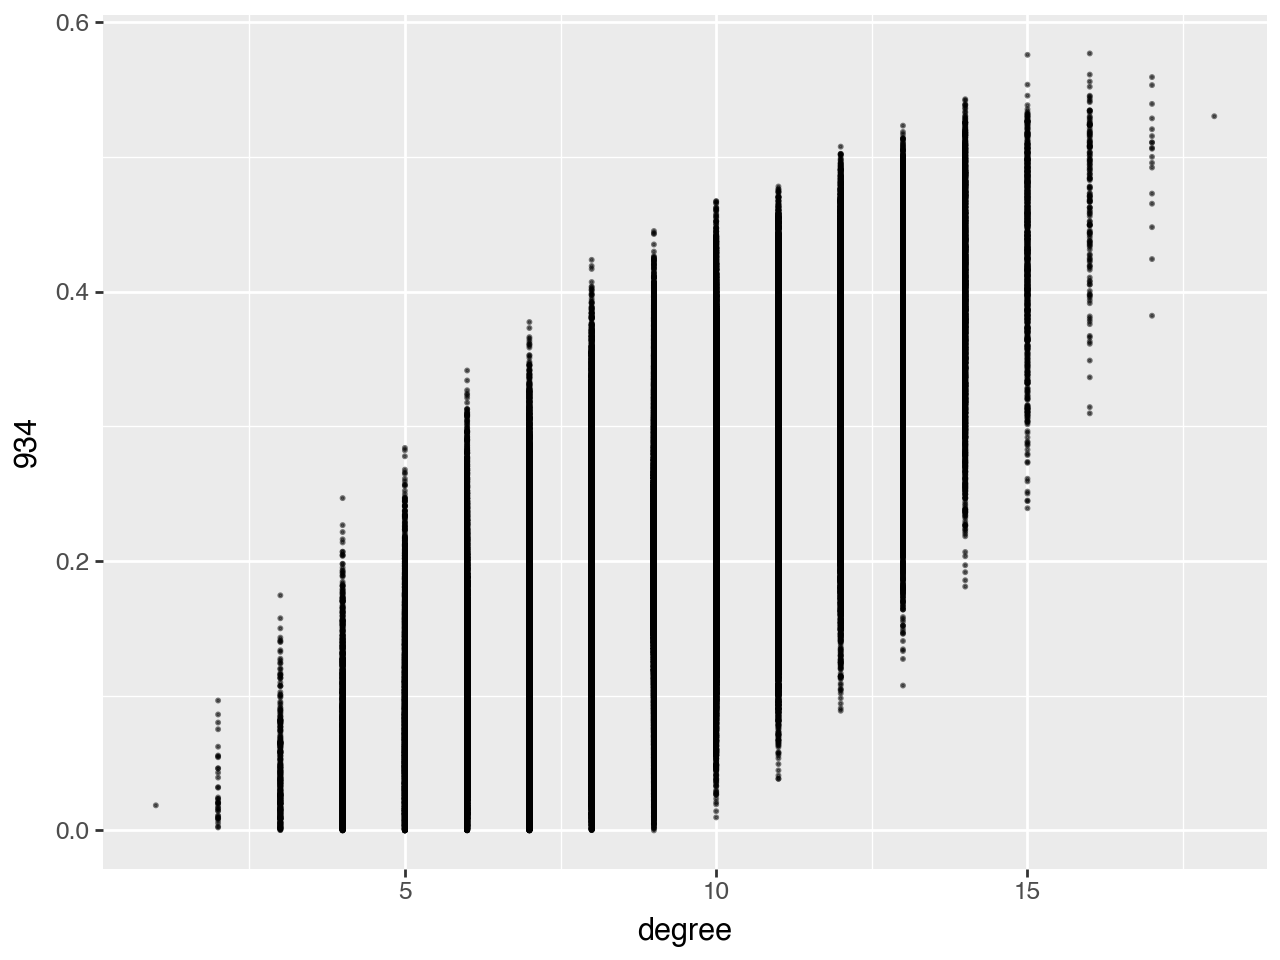

In [166]:
from random import randint

randcol = randint(0, 1023)
print(randcol)
deg1 = l1_ft[[2**(17-i) for i in range(18)], randcol]
val =  (deg1 > 0).to(torch.float32).unsqueeze(0)
print(deg1)
df = pl.DataFrame({'degree': ((boolean_cube + val) % 2).sum(dim=1).to(torch.int32).numpy(), f'{randcol}': l1_outs[:, randcol].detach().numpy()}) 
ggplot(df.filter(pl.col(str(randcol)).gt(0)), aes(y=f'{randcol}', x='degree')) + geom_point(size=0.2, alpha=0.5)

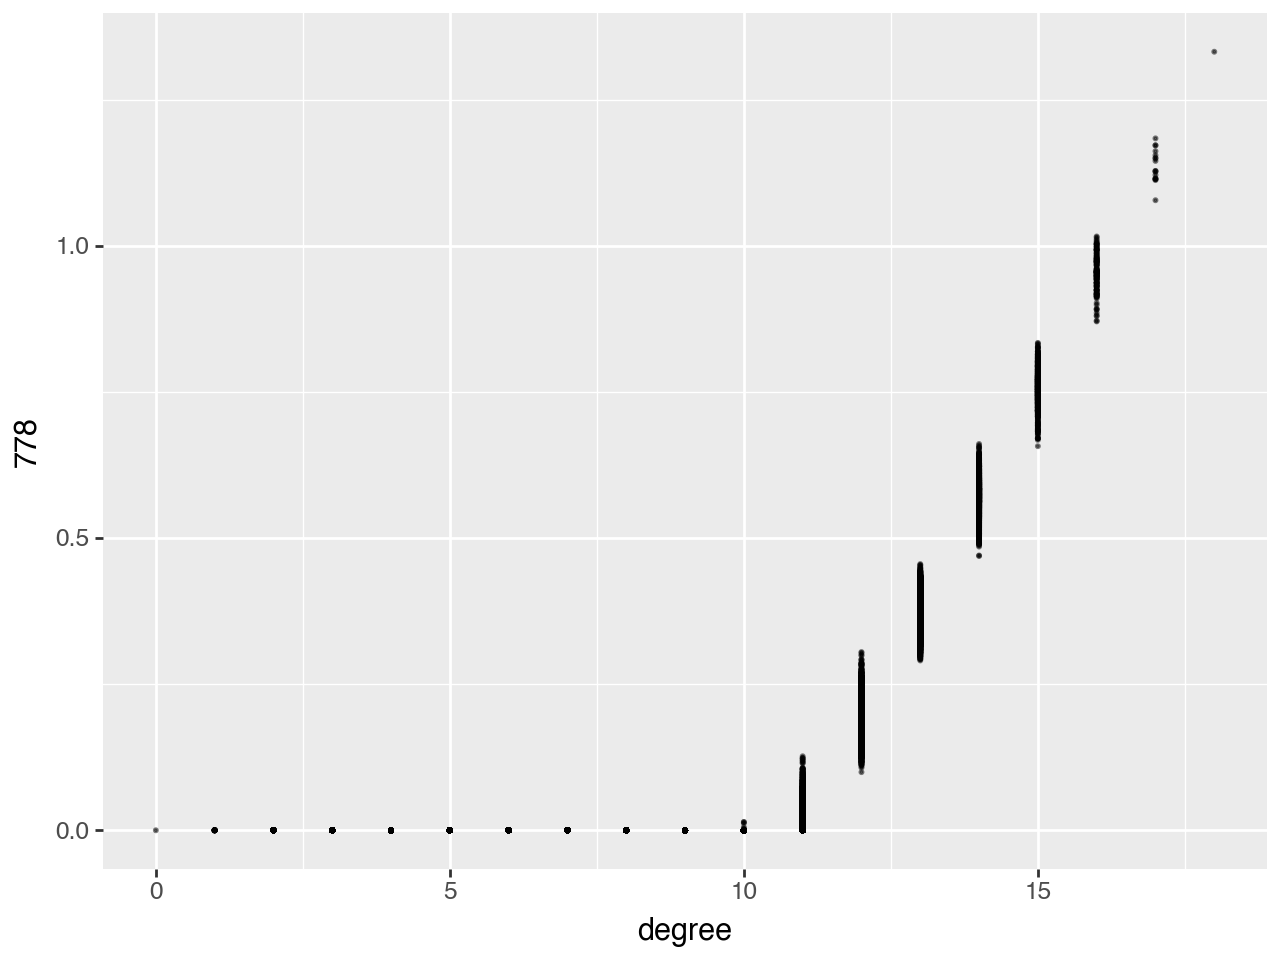

In [108]:
temp_cache['hook_linear1'][0, 96]

tensor(1.6789)

In [97]:
boolean_cube_df[2**17]

shape: (1, 4)
┌────────────────┬──────────┬───────────┬────────┐
│ bits           ┆ parities ┆ indices   ┆ degree │
│ ---            ┆ ---      ┆ ---       ┆ ---    │
│ array[i32, 18] ┆ i64      ┆ list[u32] ┆ i32    │
╞════════════════╪══════════╪═══════════╪════════╡
│ [1, 0, … 0]    ┆ 0        ┆ [0]       ┆ 1      │
└────────────────┴──────────┴───────────┴────────┘

In [83]:
(
    l1_ft_df
    .filter(pl.col('degree').eq(1))
    .select(['indices', str(i)]).sort(pl.col(str(i)).abs(), descending=True).collect()

SyntaxError: incomplete input (1937033508.py, line 1)

In [ ]:
def estimate_chow_parameters(model, num_samples=10_000, layer_name='linear1'):
    # Get the weights of the specified layer
    layer = getattr(model, layer_name)
    weights = layer.weight.data  # shape: (num_neurons, num_features)

    num_neurons, num_features = weights.shape

    # Generate random binary inputs
    inputs = torch.randint(0, 2, (num_samples, num_features), dtype=torch.float32)

    with torch.no_grad():
        # shape: (num_samples, num_neurons)
        outputs = torch.relu(inputs @ weights.T)

    # Estimate 0th order Chow parameters (bias terms)
    chow_params_0th = outputs.mean(dim=0)  # shape: (num_neurons,)

    # Estimate 1st order Chow parameters (fully vectorized)
    norm_outputs = outputs - outputs.mean(dim=0, keepdim=True)
    chow_params_1st = (inputs.T @ norm_outputs) / num_samples  # shape: (num_features, num_neurons)

    # Combine 0th and 1st order parameters
    chow_params = torch.cat([chow_params_0th.unsqueeze(0), chow_params_1st.T], dim=0)

    return chow_params.T  # shape: (num_neurons, num_features + 1)

def analyze_chow_parameters(chow_params):
    num_neurons, num_params = chow_params.shape
    
    print(f"Analyzed {num_neurons} neurons with {num_params - 1} input features each.")
    print(f"Average bias term: {chow_params[:, 0].mean():.4f}")
    print(f"Average magnitude of first-order terms: {torch.abs(chow_params[:, 1:]).mean():.4f}")
    print(f"Max magnitude of first-order terms: {torch.abs(chow_params[:, 1:]).max():.4f}")
    
    # Top influential features
    top_features = torch.argsort(torch.abs(chow_params[:, 1:]), dim=1, descending=True)[:, :5]
    print("\nTop 5 influential features for first 10 neurons:")
    for i in range(min(10, num_neurons)):
        print(f"Neuron {i}: {top_features[i].tolist()}")

chow_params = estimate_chow_parameters(model, 500_000, 'linear2')
analyze_chow_parameters(chow_params)

In [5]:
chow_params.shape

torch.Size([1024, 1025])

In [6]:
chow_params[2, 1:].pow(2).sum()

tensor(0.0582)

In [7]:
chow_params[:, 1:].pow(2).sum(axis=1).min()

tensor(0.0091)

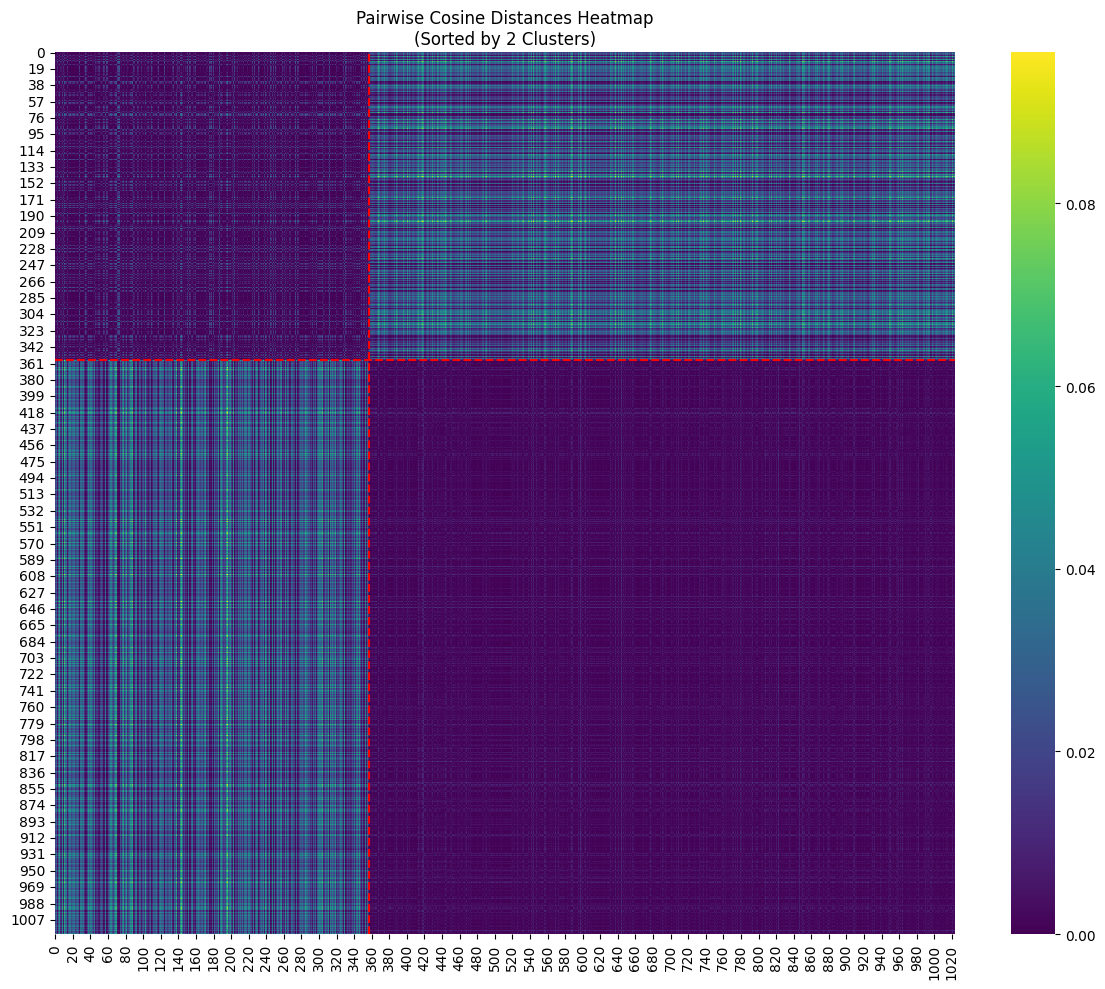

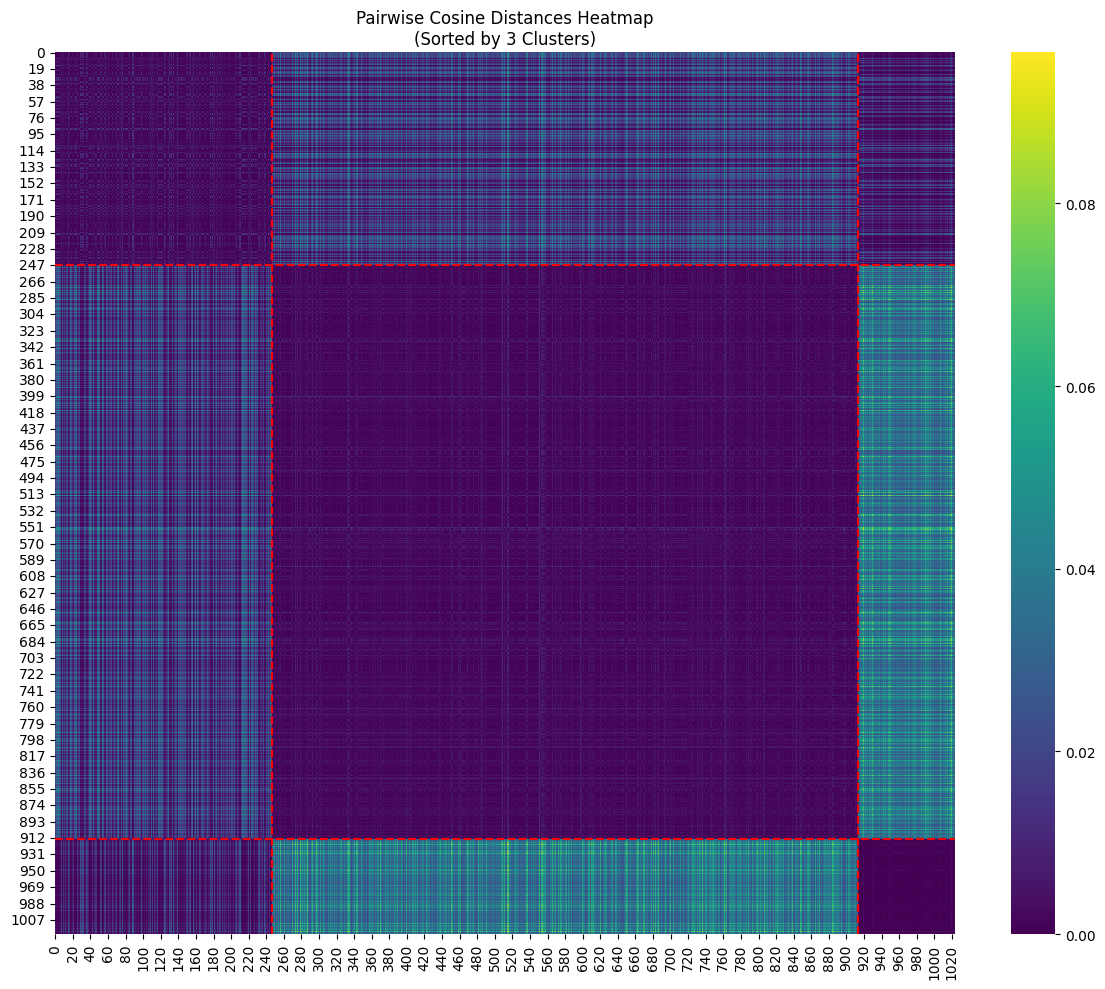

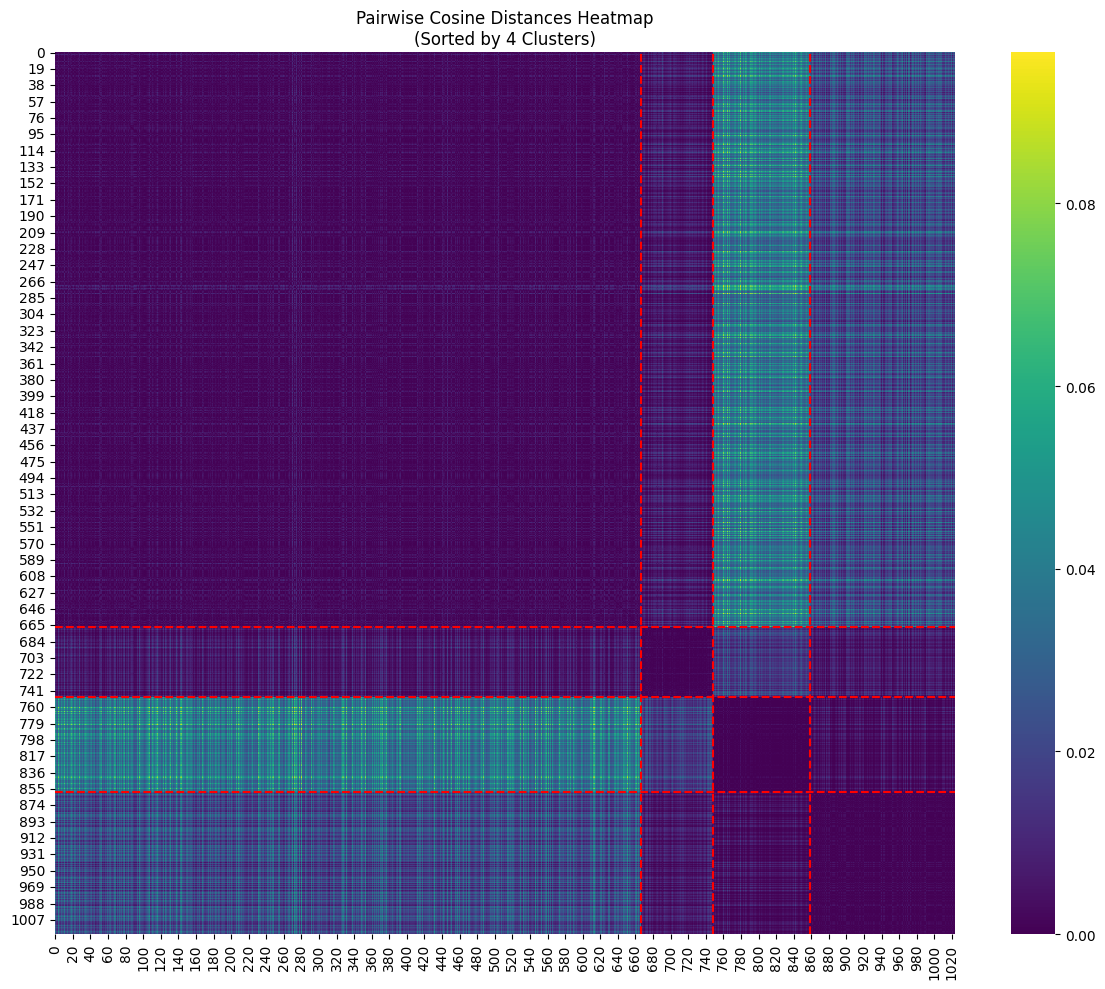

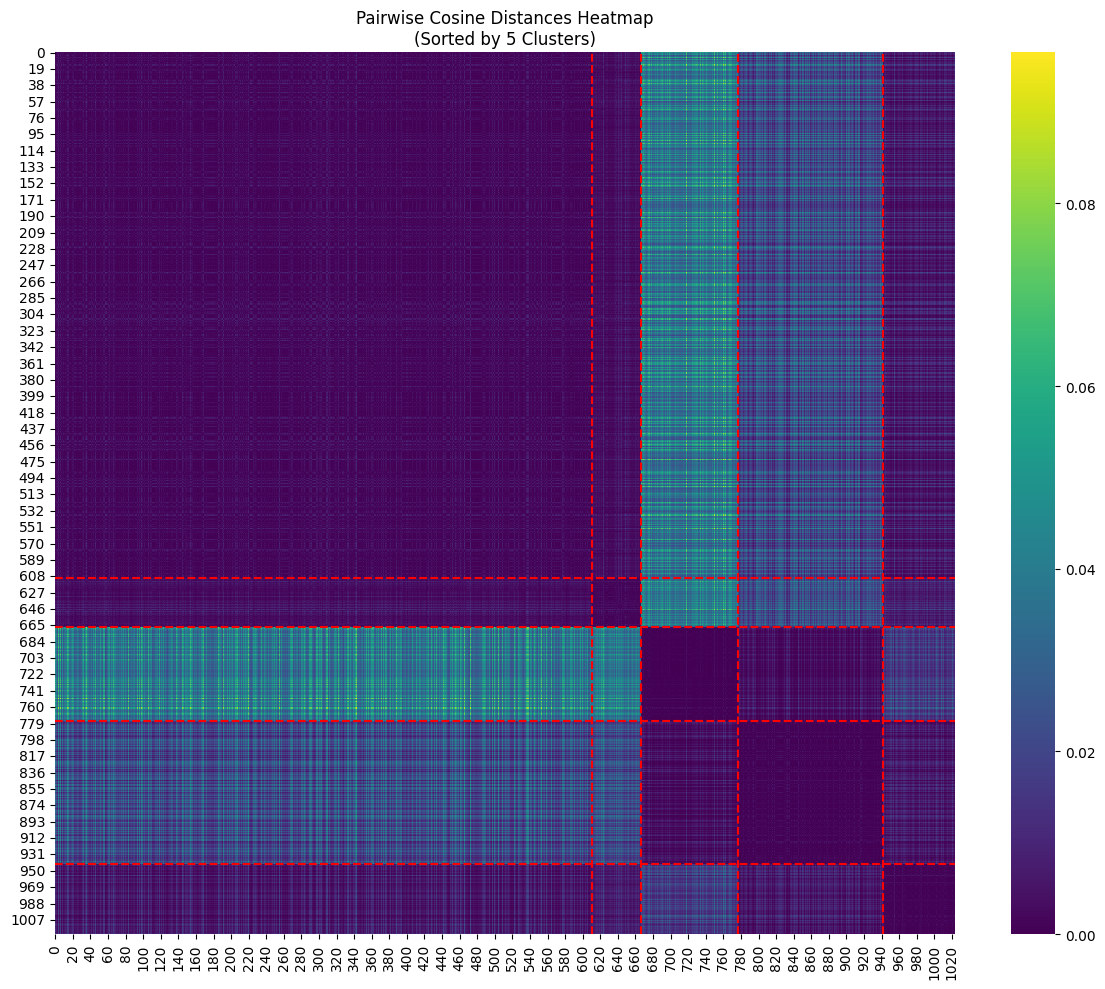

In [6]:


def canonicalize_chow_parameters(chow_params):
    """
    Canonicalize Chow parameters by taking absolute values and sorting in decreasing order.
    """
    new_params = np.sort(np.abs(chow_params), axis=1)[:, ::-1]
    return new_params / (np.linalg.norm(new_params, axis=1)[:, None])


def compute_pairwise_distances(canonicalized_params):
    """
    Compute pairwise cosine distances between canonicalized Chow parameters.
    """
    return pdist(canonicalized_params, metric='cosine')


def cluster_neurons(distances, n_clusters=5):
    """
    Cluster neurons based on their pairwise distances.
    """
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='complete')
    return clustering.fit_predict(squareform(distances))


def plot_distance_heatmap(distances, clustering, n_clusters):
    """
    Plot a heatmap of the pairwise distances with clustering.
    """
    # Convert distances to a square matrix
    dist_matrix = squareform(distances)
    
    # Sort the matrix based on clustering
    sorted_indices = np.argsort(clustering)
    sorted_matrix = dist_matrix[sorted_indices][:, sorted_indices]
    
    # Create the plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(sorted_matrix, cmap='viridis')
    
    # Add cluster separation lines
    cluster_sizes = np.bincount(clustering)
    cumulative_sizes = np.cumsum(cluster_sizes)
    for size in cumulative_sizes[:-1]:
        plt.axhline(y=size, color='red', linestyle='--')
        plt.axvline(x=size, color='red', linestyle='--')
    
    plt.title(f'Pairwise Cosine Distances Heatmap\n(Sorted by {n_clusters} Clusters)')
    plt.tight_layout()
    plt.show()


def plot_multiple_heatmaps(distances, cluster_numbers=[2, 5, 10]):
    for n_clusters in cluster_numbers:
        clustering = cluster_neurons(distances, n_clusters=n_clusters)
        plot_distance_heatmap(distances, clustering, n_clusters)



chow_biases = chow_params[:, 0].numpy()
chow_input_params = chow_params[:, 1:].numpy()

canon_params = canonicalize_chow_parameters(chow_input_params)
distances = compute_pairwise_distances(canon_params)

# Function to plot heatmaps for different numbers of clusters
plot_multiple_heatmaps(distances, cluster_numbers=[2, 3, 4, 5])

In [9]:
np.argwhere(np.isnan(distances))

array([], shape=(0, 1), dtype=int64)

In [10]:
np.linalg.norm(chow_input_params, axis=1)

array([0.2904489 , 0.2694946 , 0.24115606, ..., 0.1021998 , 0.26644468,
       0.14127076], dtype=float32)

In [11]:
clusters = cluster_neurons(distances, 3)

In [12]:
np.set_printoptions(precision=4, suppress=True)

In [13]:
from random import randint

cluster = 1
cluster_indices = np.argwhere(clusters == cluster).squeeze()

idx = randint(0, len(cluster_indices) - 1)
i = cluster_indices[idx]
#i = 749
print(i, clusters[i])
print(canon_params[i, :256])
print(canon_params[i, -128:])

172 1
[0.0872 0.0568 0.056  0.0555 0.0553 0.0549 0.0546 0.0544 0.0544 0.0543
 0.0543 0.0542 0.0542 0.0542 0.054  0.0539 0.0538 0.0538 0.0537 0.0536
 0.0535 0.0533 0.0532 0.0532 0.0531 0.053  0.0526 0.0524 0.0523 0.0522
 0.0521 0.0521 0.052  0.052  0.0519 0.0519 0.0519 0.0519 0.0518 0.0517
 0.0515 0.0515 0.0515 0.051  0.051  0.051  0.051  0.0506 0.0505 0.0505
 0.0505 0.0502 0.0501 0.0501 0.0499 0.0499 0.0498 0.0498 0.0498 0.0496
 0.0494 0.0494 0.0494 0.0493 0.0493 0.0492 0.0489 0.0489 0.0489 0.0487
 0.0486 0.0485 0.0485 0.0485 0.0483 0.0483 0.0483 0.0481 0.0481 0.048
 0.0478 0.0477 0.0477 0.0475 0.0475 0.0475 0.0474 0.0474 0.0473 0.0473
 0.0472 0.0472 0.0472 0.0471 0.0471 0.0471 0.047  0.0469 0.0468 0.0468
 0.0468 0.0468 0.0467 0.0467 0.0467 0.0467 0.0465 0.0462 0.0461 0.0461
 0.0461 0.046  0.0459 0.0459 0.0458 0.0457 0.0457 0.0457 0.0456 0.0455
 0.0455 0.0455 0.0455 0.0454 0.0453 0.0452 0.0452 0.0451 0.0451 0.045
 0.0448 0.0448 0.0448 0.0447 0.0447 0.0446 0.0445 0.0445 0.0443 0.0442
 0

In [14]:
i = randint(0, 1023)
w = model.linear2.weight[i].abs().sort()[0].detach().numpy()[::-1]


print(w[:128])
print(w[-128:])

[0.126  0.1245 0.1163 0.1075 0.0987 0.0937 0.0931 0.0913 0.0906 0.0905
 0.0903 0.0903 0.0867 0.0851 0.0841 0.0836 0.0827 0.0825 0.0814 0.0813
 0.0796 0.0784 0.0773 0.0768 0.0764 0.0763 0.076  0.0759 0.0751 0.0749
 0.0746 0.074  0.074  0.0738 0.073  0.0728 0.0726 0.0721 0.0706 0.0703
 0.0703 0.0703 0.07   0.0693 0.0693 0.0693 0.069  0.0686 0.0685 0.0683
 0.0681 0.0681 0.068  0.0679 0.0678 0.0676 0.0675 0.0672 0.067  0.0668
 0.0664 0.0664 0.0659 0.0657 0.0656 0.0655 0.0653 0.0649 0.0644 0.0641
 0.0639 0.0639 0.0637 0.0634 0.0632 0.0627 0.0626 0.0624 0.0621 0.0619
 0.0619 0.0616 0.0613 0.0612 0.0611 0.0609 0.0608 0.0607 0.0604 0.0601
 0.0601 0.06   0.0597 0.0597 0.0595 0.0592 0.0592 0.0589 0.0585 0.0585
 0.0584 0.0582 0.058  0.0577 0.0577 0.0576 0.0576 0.0574 0.0572 0.0572
 0.057  0.0569 0.0568 0.0566 0.0565 0.0565 0.0562 0.0561 0.0561 0.056
 0.056  0.0558 0.0557 0.0556 0.0554 0.0553 0.0552 0.0551]
[0.0053 0.0052 0.0052 0.0052 0.0052 0.0052 0.0052 0.0052 0.0051 0.0051
 0.0051 0.005  0.005

In [15]:
vals, indices = model.linear2.weight.abs().sort(dim=1, descending=True)

In [16]:
model.linear2.weight[0].abs().sort(descending=True)[1] == indices[0]

tensor([True, True, True,  ..., True, True, True])

In [636]:
perm_mat = torch.eye(1024)[:, indices[0]]

In [637]:
perm_mat.shape

torch.Size([1024, 1024])

In [640]:
indices[0]

tensor([891, 959, 499,  ..., 129, 902, 213])

In [638]:
model.linear2.weight[0].abs() @ perm_mat

tensor([1.3516e-01, 1.0459e-01, 9.5740e-02,  ..., 8.9958e-05, 6.7065e-05,
        3.8216e-05], grad_fn=<SqueezeBackward4>)

In [627]:
vals[0]

tensor([1.3516e-01, 1.0459e-01, 9.5740e-02,  ..., 8.9958e-05, 6.7065e-05,
        3.8216e-05], grad_fn=<SelectBackward0>)

In [17]:
@torch.vmap
def make_perm_matrix(permutation):
    return torch.eye(len(permutation))[:, permutation]

In [706]:
all_perms = make_perm_matrix(indices)

In [705]:

i = randint(0, 1024 - 10 - 1)
j = randint(0, 1024 - 10 - 1)
print(f"{i}:{i+10}, {j}:{j+10}")
mean_perms[i:(i+10), j:(j+10)].numpy()

515:525, 379:389


array([[2., 3., 0., 1., 2., 2., 1., 2., 3., 2.],
       [1., 5., 2., 0., 1., 2., 3., 2., 3., 0.],
       [3., 4., 0., 1., 2., 1., 1., 0., 2., 1.],
       [3., 0., 1., 1., 2., 4., 3., 0., 0., 3.],
       [0., 0., 2., 0., 1., 1., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1., 2., 2., 0., 1., 0.],
       [0., 1., 0., 0., 1., 2., 2., 0., 0., 0.],
       [1., 0., 2., 0., 2., 0., 1., 2., 3., 1.],
       [2., 1., 0., 0., 0., 0., 2., 1., 0., 1.],
       [3., 3., 1., 0., 0., 2., 3., 2., 0., 2.]], dtype=float32)

In [914]:

i = randint(0, 1024 - 1)
j = randint(0, 1024 - 1)
weights = torch.arange(1024).sort(descending=True)[0].unsqueeze(1).sqrt()
print(i, j)
print(torch.trace((all_perms[i] * weights)@ (all_perms[j] * weights).T).item())
print(torch.trace(all_perms[i] @ all_perms[j].T).item())


811 924
891.0
1.0
-496.0


In [973]:
i = randint(0, 1024 - 1)
j = randint(0, 1024 - 1)
print(torch.dot(torch.sign(model.linear1.weight[i]), torch.sign(model.linear1.weight[j])).item())

62.0


In [43]:
i = randint(0, 1024 - 1)
print(i)
torch.sign(model.linear1.weight[i]).sum().item()

412


-20.0

/Users/dashiell/workspace/deep-parity/.venv/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 468'. Pick better value with 'binwidth'.


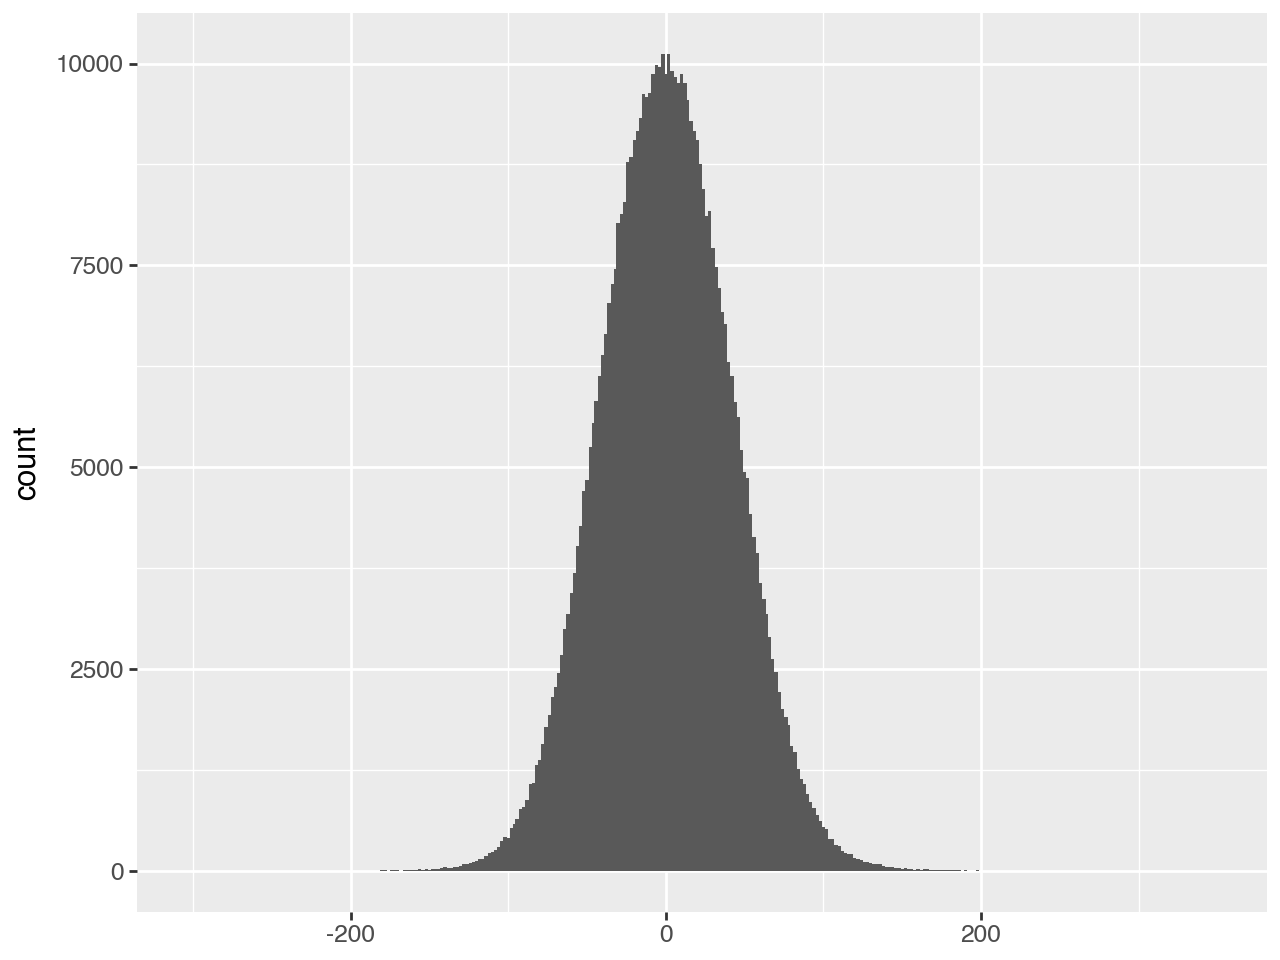

In [31]:
from plotnine import qplot, geom_histogram
distances = torch.sign(model.linear1.weight) @ torch.sign(model.linear1.weight.T)
qplot(distances[idx[0], idx[1]].detach().numpy()) + geom_histogram(binwidth=2)

In [10]:
boolean_cube = torch.tensor(generate_all_binary_arrays(18), dtype=torch.float32)

In [11]:
logits, cache = model.run_with_cache(boolean_cube)

In [12]:
from torch.nn.functional import relu
l1_outs = relu(cache['hook_linear1'])
l1_outs.shape

torch.Size([262144, 1024])

In [664]:
import numpy as np

def calculate_ltf_indices(weights, tau, gamma):
    """
    Calculate the critical index l and the opposite index m for a Linear Threshold Function.
    
    :param weights: numpy array of weights, assumed to be sorted in descending order
    :param tau: threshold for critical index l
    :param gamma: threshold for opposite index m
    :return: tuple (l, m)
    """
    n = len(weights)
    
    # Calculate reverse cumulative sum (tail sums)
    tail_sums = np.cumsum(weights[::-1])[::-1]
    
    # Calculate ratios
    l_ratios = weights / tail_sums
    m_ratios = weights[:-1] / tail_sums[1:]
    
    # Find critical index l
    l = next((i for i, r in enumerate(l_ratios) if r <= tau), np.inf)
    
    # Find opposite index m
    m = next((i for i, r in enumerate(m_ratios[1:], 1) if r >= gamma), np.inf)
    
    return l, m

# Example usage

tau = 0.01
gamma = 10.0

weights = model.linear2.weight.detach().numpy()
weights /= np.linalg.norm(weights, axis=1)[:, None]
squared_weights = np.sort(weights ** 2, axis=1)[:, ::-1]


In [458]:
i = randint(0, 1023)

l, m = calculate_ltf_indices(squared_weights[i], tau, gamma)
print(i)
print(l, m)

49
3 inf


In [44]:
def make_base_parity_dataframe(n):
    all_binary_data = generate_all_binary_arrays(n).astype(np.int32)
    #all_binary_data = np.sign(-1 * all_binary_data_zero_one + 0.5)
    all_parities = all_binary_data.sum(axis=1)
    base_df = pl.DataFrame({
        'bits': all_binary_data, 
        'parities': all_parities, 
    })
    base_df = base_df.with_columns(
        indices=pl.col('bits').arr.to_list().list.eval(pl.arg_where(pl.element() == 1)),
  
    )
    return base_df


def calc_power_contributions(tensor, n, epoch):
    linear_dim = tensor.shape[1]
    base_df = make_base_parity_dataframe(n)
    centered_tensor = tensor - tensor.mean(dim=0, keepdims=True)
    ft = fourier_transform(centered_tensor.T)
    #ft /= ft.mean(dim=0, keepdims=True)
    linear_df = pl.DataFrame(
        ft.T.detach().cpu().numpy(),
        schema=[str(i) for i in range(linear_dim)]
    )
    data = pl.concat([base_df, linear_df], how='horizontal')
    total_power = (
        data
        .select(pl.exclude('bits', 'parities', 'indices', 'degree'))
        .unpivot()
        .with_columns(pl.col('variable').str.to_integer())
        .group_by('variable').agg(pl.col('value').pow(2).sum())
        .rename({'value': 'power'})
    )
    power_df = (
        data
        .select(pl.exclude('bits', 'parities', 'indices'))
        .unpivot(index='degree')
        .with_columns(pl.col('variable').str.to_integer())
        .group_by('degree', 'variable').agg(pl.col('value').pow(2).sum())
        .join(total_power, on='variable', how='left')
        .with_columns(pcnt_power = pl.col('value') / pl.col('power'), epoch=pl.lit(epoch))
    )
    return power_df


In [31]:
l1_ft = fourier_transform(l1_outs.T).T

In [43]:
l1_outs

tensor([[0.0225, 0.0130, 0.1868,  ..., 0.0000, 0.0289, 0.0739]])

In [256]:
l1_ft_df = pl.concat([boolean_cube_df, pl.DataFrame(l1_ft.detach().numpy(), schema=[str(i) for i in range(1024)])], how='horizontal')

In [ ]:
l1_ft_df.head()

In [45]:
l1_power_df = calc_power_contributions(l1_outs, 18, 20_000)

In [36]:
l1_outs[:, 200].pow(2).sum()

tensor(0.)

In [33]:
l1_ft[:, 616].pow(2).sum()

tensor(0.)

In [54]:
l1_power_df.filter(pl.col('power').gt(0)).filter(pl.col('degree').eq(12)).sort('pcnt_power', descending=True)

shape: (873, 6)
┌────────┬──────────┬───────────┬──────────────┬────────────┬───────┐
│ degree ┆ variable ┆ value     ┆ power        ┆ pcnt_power ┆ epoch │
│ ---    ┆ ---      ┆ ---       ┆ ---          ┆ ---        ┆ ---   │
│ i32    ┆ i64      ┆ f32       ┆ f32          ┆ f32        ┆ i32   │
╞════════╪══════════╪═══════════╪══════════════╪════════════╪═══════╡
│ 12     ┆ 253      ┆ 0.000004  ┆ 0.000056     ┆ 0.075138   ┆ 20000 │
│ 12     ┆ 467      ┆ 0.000004  ┆ 0.000057     ┆ 0.073012   ┆ 20000 │
│ 12     ┆ 235      ┆ 2.8047e-7 ┆ 0.000004     ┆ 0.071041   ┆ 20000 │
│ 12     ┆ 699      ┆ 1.1701e-7 ┆ 0.000002     ┆ 0.071017   ┆ 20000 │
│ 12     ┆ 335      ┆ 0.000002  ┆ 0.000028     ┆ 0.070932   ┆ 20000 │
│ …      ┆ …        ┆ …         ┆ …            ┆ …          ┆ …     │
│ 12     ┆ 487      ┆ 3.023172  ┆ 48032.601562 ┆ 0.000063   ┆ 20000 │
│ 12     ┆ 24       ┆ 0.307387  ┆ 6164.537598  ┆ 0.00005    ┆ 20000 │
│ 12     ┆ 133      ┆ 0.321837  ┆ 10035.958008 ┆ 0.000032   ┆ 20000 │
│ 12     ┆ 574      ┆ 0.442437  ┆ 19586.396484 ┆ 0.000023   ┆ 20000 │
│ 12     ┆ 650      ┆ 0.561464  ┆ 68170.9375   ┆ 0.000008   ┆ 20000 │
└────────┴──────────┴───────────┴──────────────┴────────────┴───────┘

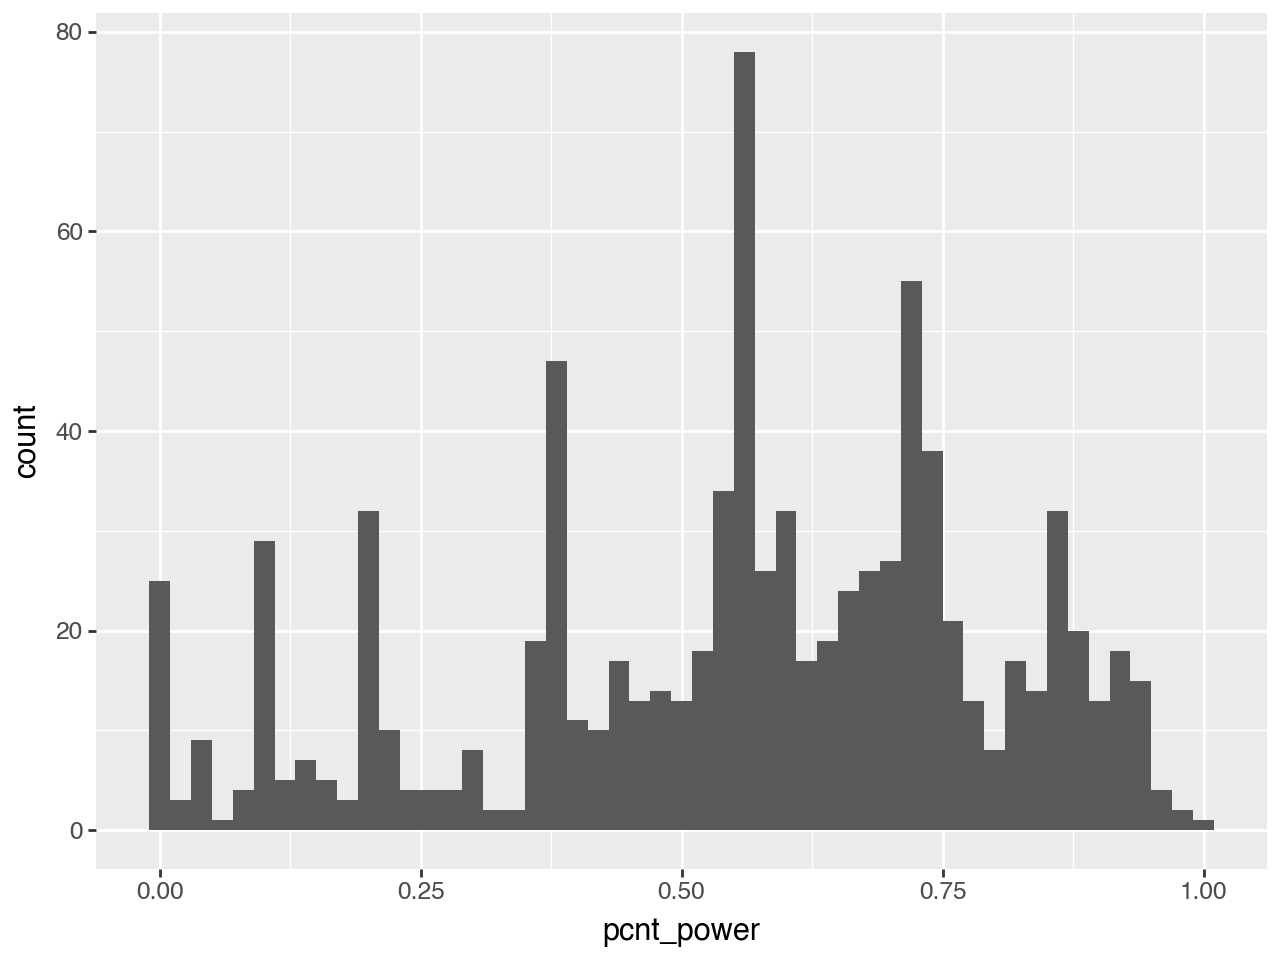

In [71]:
ggplot(l1_power_df.filter(pl.col('power').gt(0) & pl.col('degree').eq(1)), aes(x='pcnt_power')) + geom_histogram(binwidth=0.02)

In [237]:
high_degree = l1_power_df.filter(pl.col('power').gt(100) & pl.col('degree').eq(2) & pl.col('pcnt_power').gt(0.25))['variable'].to_list()

779


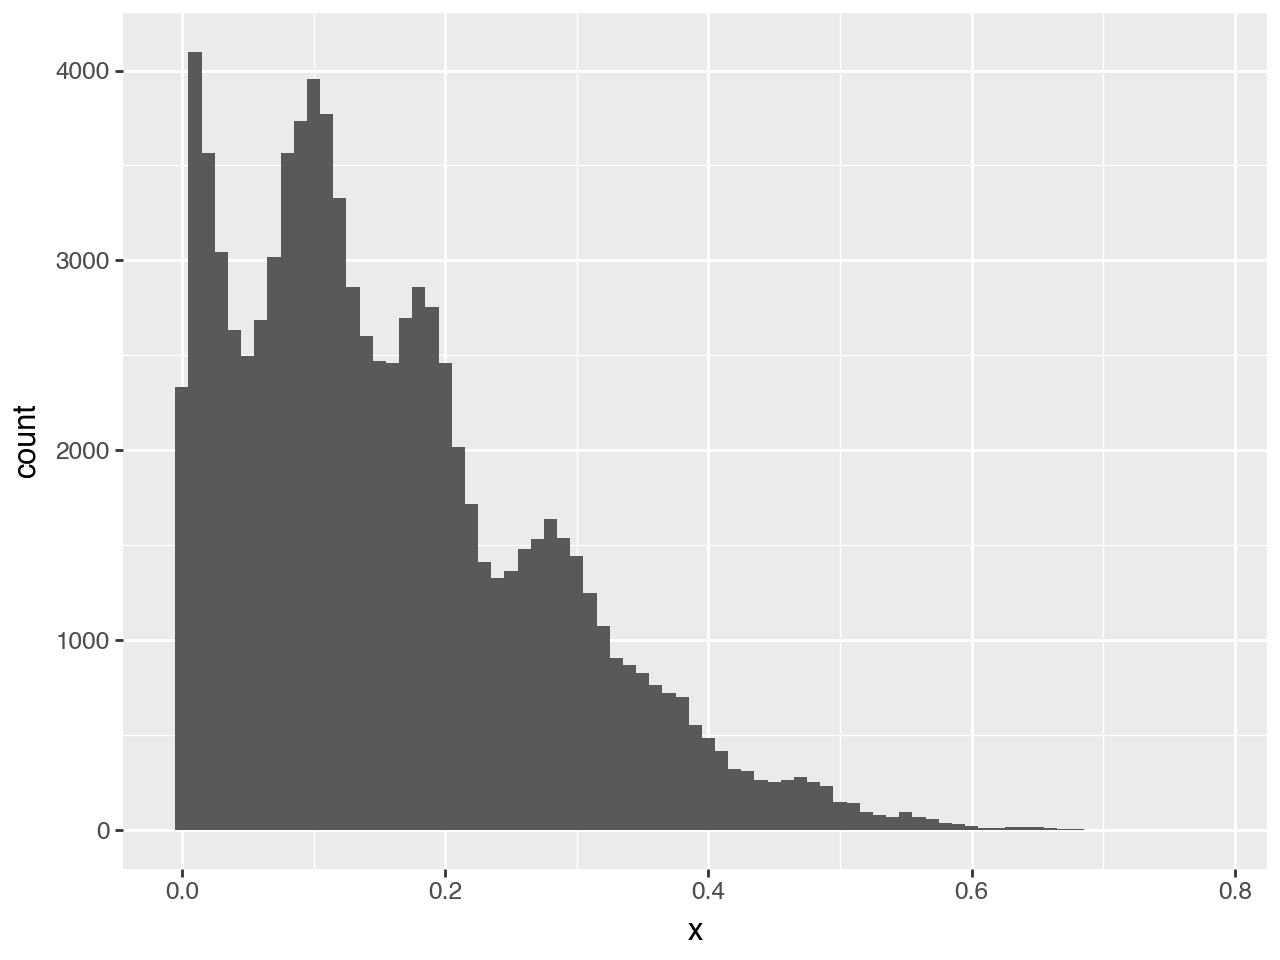

In [245]:
from random import choice
from plotnine import scale_y_log10
col_idx = choice(high_degree)
print(col_idx)
df = pl.DataFrame({'x': l1_outs[l1_outs[:, col_idx] > 0, col_idx].numpy()})
ggplot(df, aes(x='x')) + geom_histogram(binwidth=0.01)

28


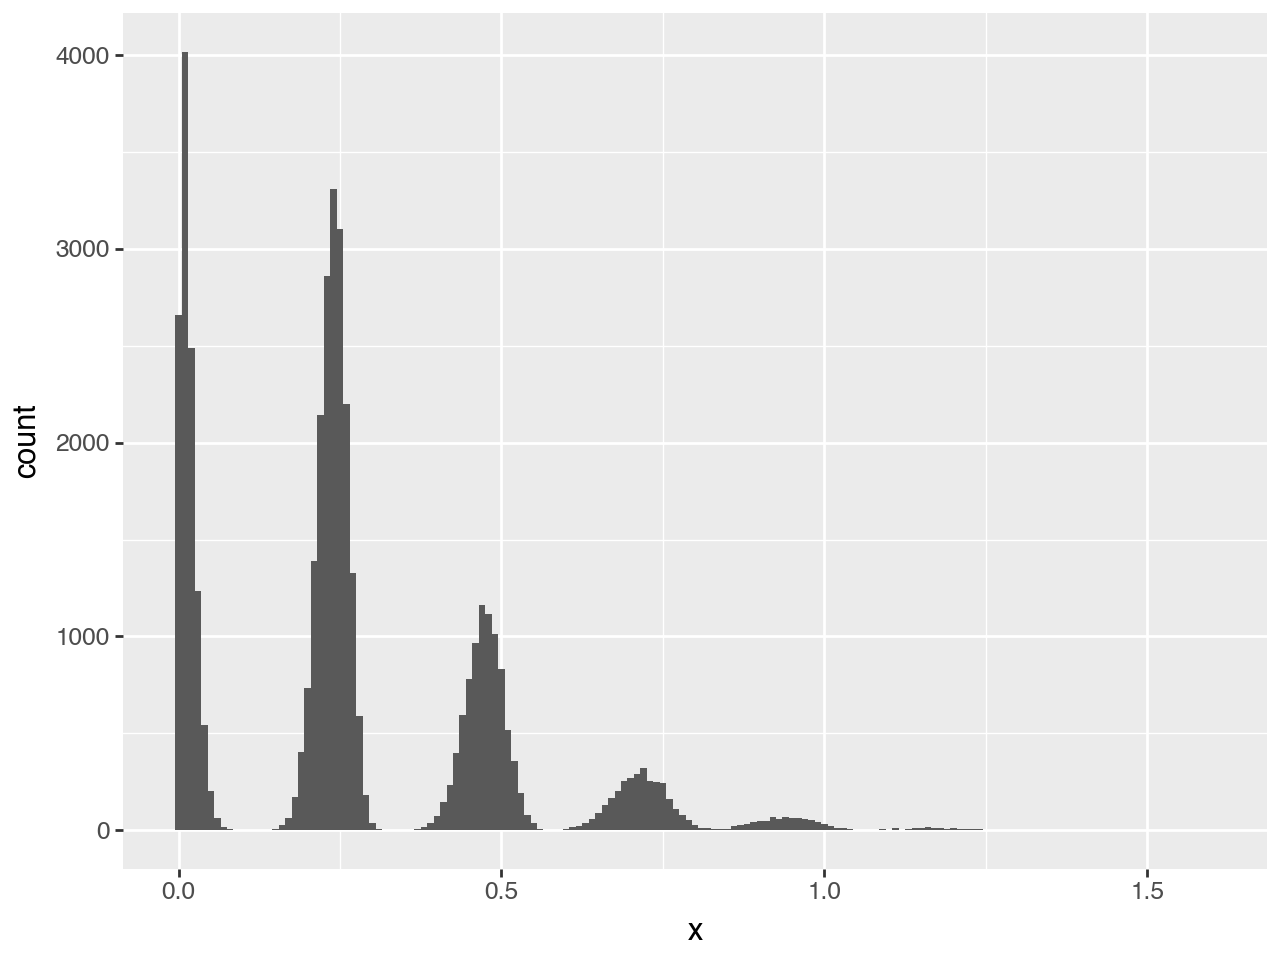

In [175]:
from random import randint

col_idx = randint(0, 1023)
#col_idx = 154
df = pl.DataFrame({'x': l1_outs[l1_outs[:, col_idx] > 0, col_idx].numpy()})
print(col_idx)
ggplot(df, aes(x='x')) + geom_histogram(binwidth=0.01)


In [192]:
_, sorted_indices = model.linear1.weight[:, 28].detach().abs().sort()
model.linear1.weight[:, 28].detach()[sorted_indices][600:900]

tensor([ 0.0163, -0.0163, -0.0163, -0.0164, -0.0165,  0.0165, -0.0165,  0.0166,
         0.0166, -0.0167,  0.0167, -0.0168,  0.0168,  0.0168, -0.0168, -0.0169,
         0.0169,  0.0169,  0.0169, -0.0170, -0.0170,  0.0170, -0.0170, -0.0171,
         0.0171, -0.0171,  0.0172,  0.0172,  0.0172, -0.0173,  0.0173, -0.0173,
         0.0173, -0.0173,  0.0173, -0.0173, -0.0174, -0.0174, -0.0174, -0.0174,
        -0.0174, -0.0174, -0.0174,  0.0174, -0.0175, -0.0175,  0.0175,  0.0176,
        -0.0176, -0.0176, -0.0176, -0.0176, -0.0176, -0.0176,  0.0177, -0.0177,
         0.0177, -0.0177,  0.0177,  0.0177, -0.0178, -0.0178,  0.0178, -0.0178,
        -0.0179,  0.0180,  0.0180,  0.0180, -0.0180, -0.0180, -0.0180, -0.0180,
        -0.0181, -0.0181, -0.0181, -0.0182, -0.0182, -0.0183,  0.0183,  0.0183,
        -0.0183,  0.0183,  0.0184, -0.0184, -0.0184,  0.0184,  0.0185,  0.0185,
         0.0185, -0.0185, -0.0185, -0.0185,  0.0185,  0.0185, -0.0185, -0.0185,
         0.0187,  0.0188, -0.0188,  0.01

In [201]:
weights_df = pl.DataFrame({str(i): vec.detach().squeeze().numpy() for i, vec in enumerate(model.linear1.weight.split(1, dim=1))})

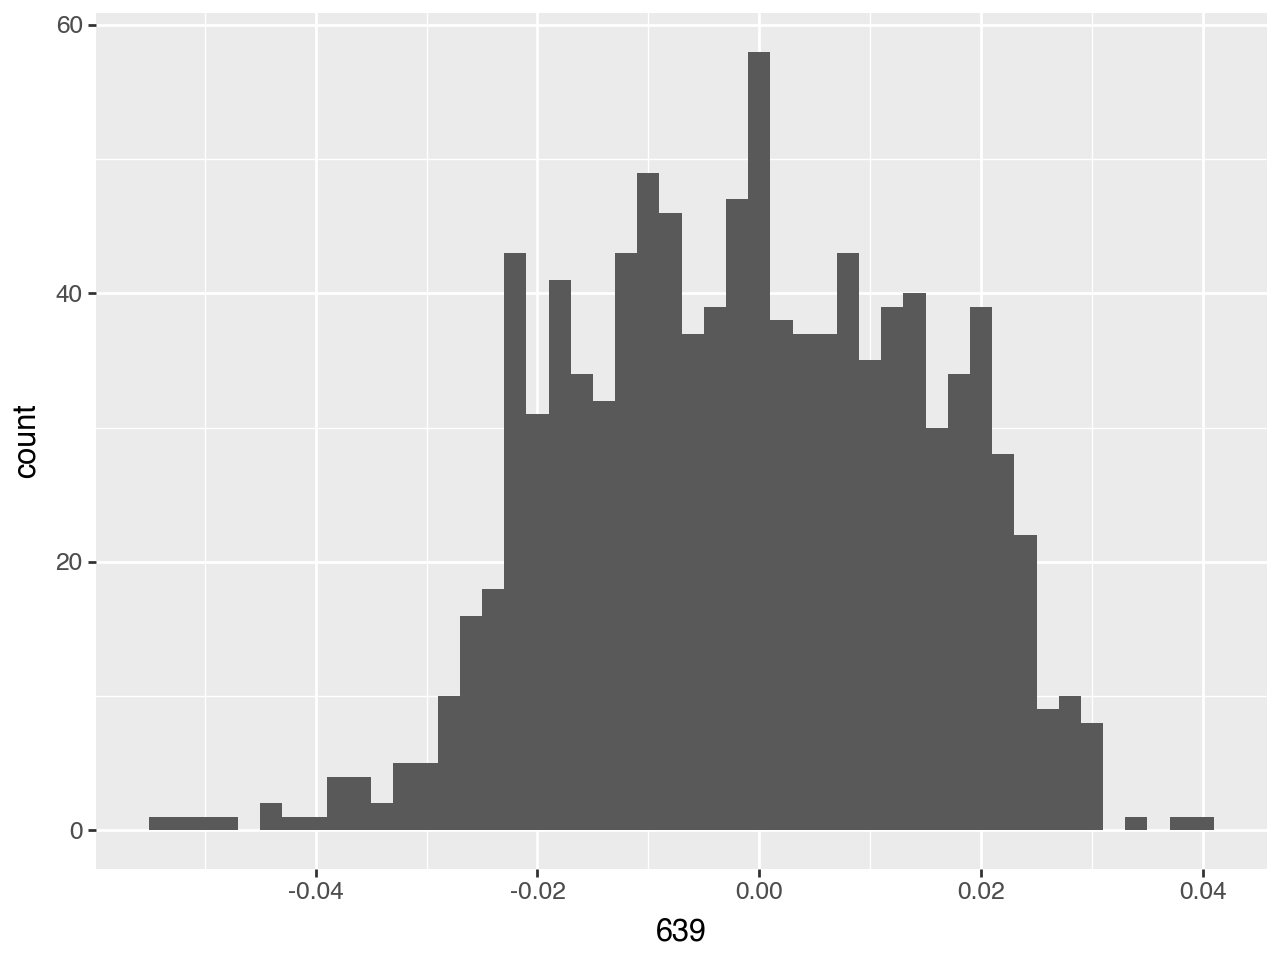

In [230]:
randcol = randint(0, 1023)

ggplot(weights_df, aes(x=str(randcol))) + geom_histogram(binwidth=0.002)

639


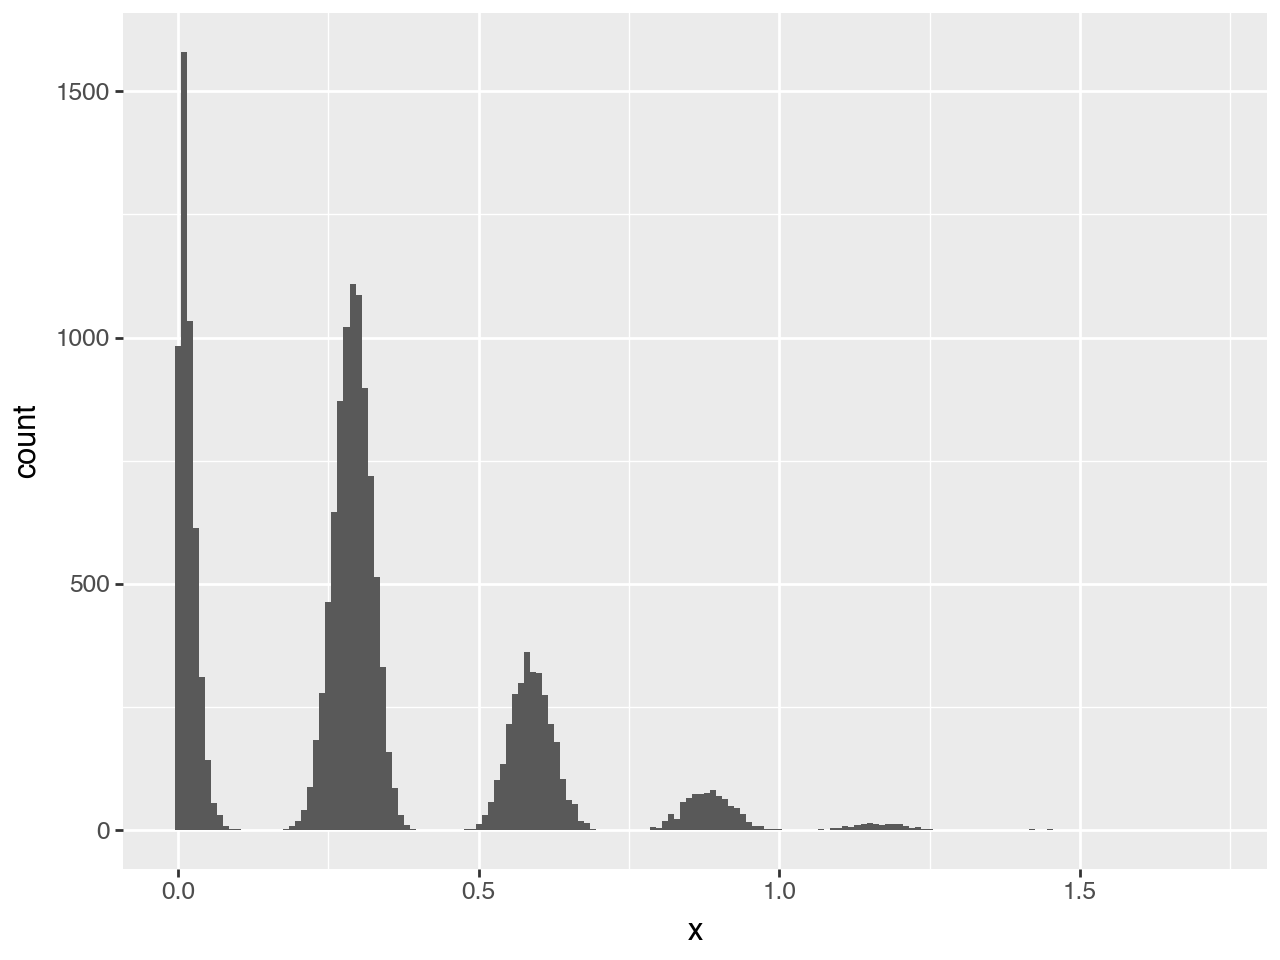

In [231]:
df = pl.DataFrame({'x': l1_outs[l1_outs[:, randcol] > 0, randcol].numpy()})
print(randcol)
ggplot(df, aes(x='x')) + geom_histogram(binwidth=0.01)


In [223]:
df

shape: (65_824, 1)
┌──────────┐
│ x        │
│ ---      │
│ f32      │
╞══════════╡
│ 0.0      │
│ 0.0      │
│ 0.0      │
│ 0.0      │
│ 0.067402 │
│ …        │
│ 0.0      │
│ 0.0      │
│ 0.0      │
│ 0.0      │
│ 0.0      │
└──────────┘

759


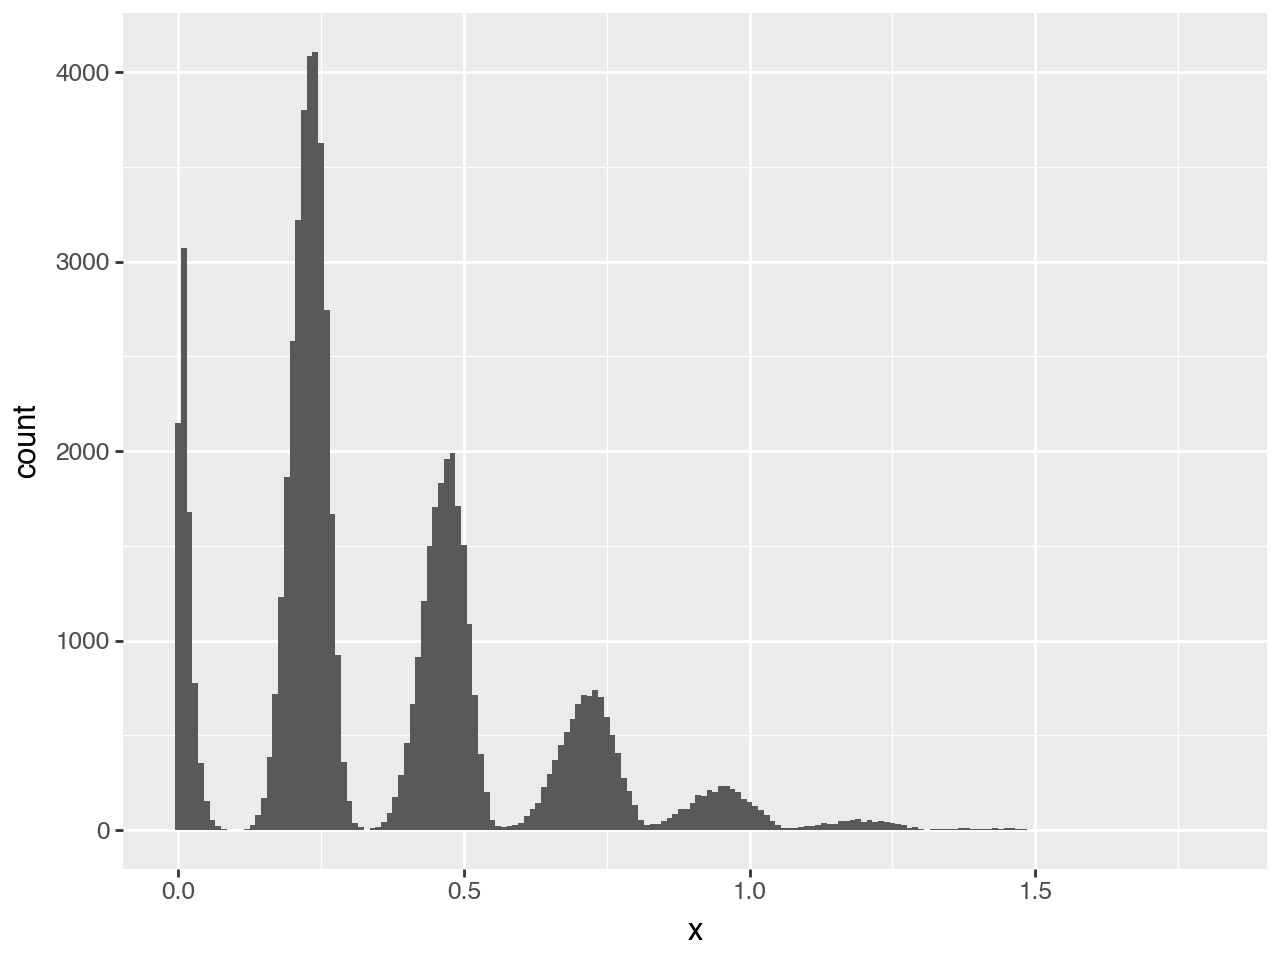

In [252]:
from random import choice
from plotnine import scale_y_log10
col_idx = choice(high_degree)
print(col_idx)
df = pl.DataFrame({'x': l1_outs[l1_outs[:, col_idx] > 0, col_idx].numpy()})
ggplot(df, aes(x='x')) + geom_histogram(binwidth=0.01)

In [ ]:
l1_ft_df.select(pl.exclude(['bits', 'parities'])).unpivot(index=['indices', 'degree']).head()

In [360]:
from itertools import product
col_idx = randint(0, 1023)
#col_idx = 759
df = l1_ft_df.select(['bits', 'parities', 'indices', 'degree', str(col_idx)])
print(col_idx)
for i, j in product(range(18), range(18)):
    if i > j:
        continue
    influence = (df.filter((pl.col('bits').arr.get(i) == 1) & (pl.col('bits').arr.get(j) == 1))[str(col_idx)].to_numpy() ** 2).sum()
    tabs = '\t' if i != j else '\t\t'
    print(tabs, (i, j), float(influence))

816
		 (0, 0) 718.6594848632812
	 (0, 1) 124.24237060546875
	 (0, 2) 135.32305908203125
	 (0, 3) 128.81533813476562
	 (0, 4) 130.33619689941406
	 (0, 5) 119.83406829833984
	 (0, 6) 127.35030364990234
	 (0, 7) 124.56797790527344
	 (0, 8) 126.3123779296875
	 (0, 9) 127.54290771484375
	 (0, 10) 126.69904327392578
	 (0, 11) 132.25653076171875
	 (0, 12) 129.30722045898438
	 (0, 13) 126.14459228515625
	 (0, 14) 125.188232421875
	 (0, 15) 130.33807373046875
	 (0, 16) 129.38330078125
	 (0, 17) 130.373046875
		 (1, 1) 724.7788696289062
	 (1, 2) 127.66258239746094
	 (1, 3) 124.62603759765625
	 (1, 4) 122.82699584960938
	 (1, 5) 121.53362274169922
	 (1, 6) 128.01121520996094
	 (1, 7) 125.34205627441406
	 (1, 8) 127.6995849609375
	 (1, 9) 125.98971557617188
	 (1, 10) 124.55215454101562
	 (1, 11) 124.64900970458984
	 (1, 12) 124.47856903076172
	 (1, 13) 127.09219360351562
	 (1, 14) 126.50155639648438
	 (1, 15) 121.46800231933594
	 (1, 16) 126.02193450927734
	 (1, 17) 125.24333190917969
		 (2, 2) 74

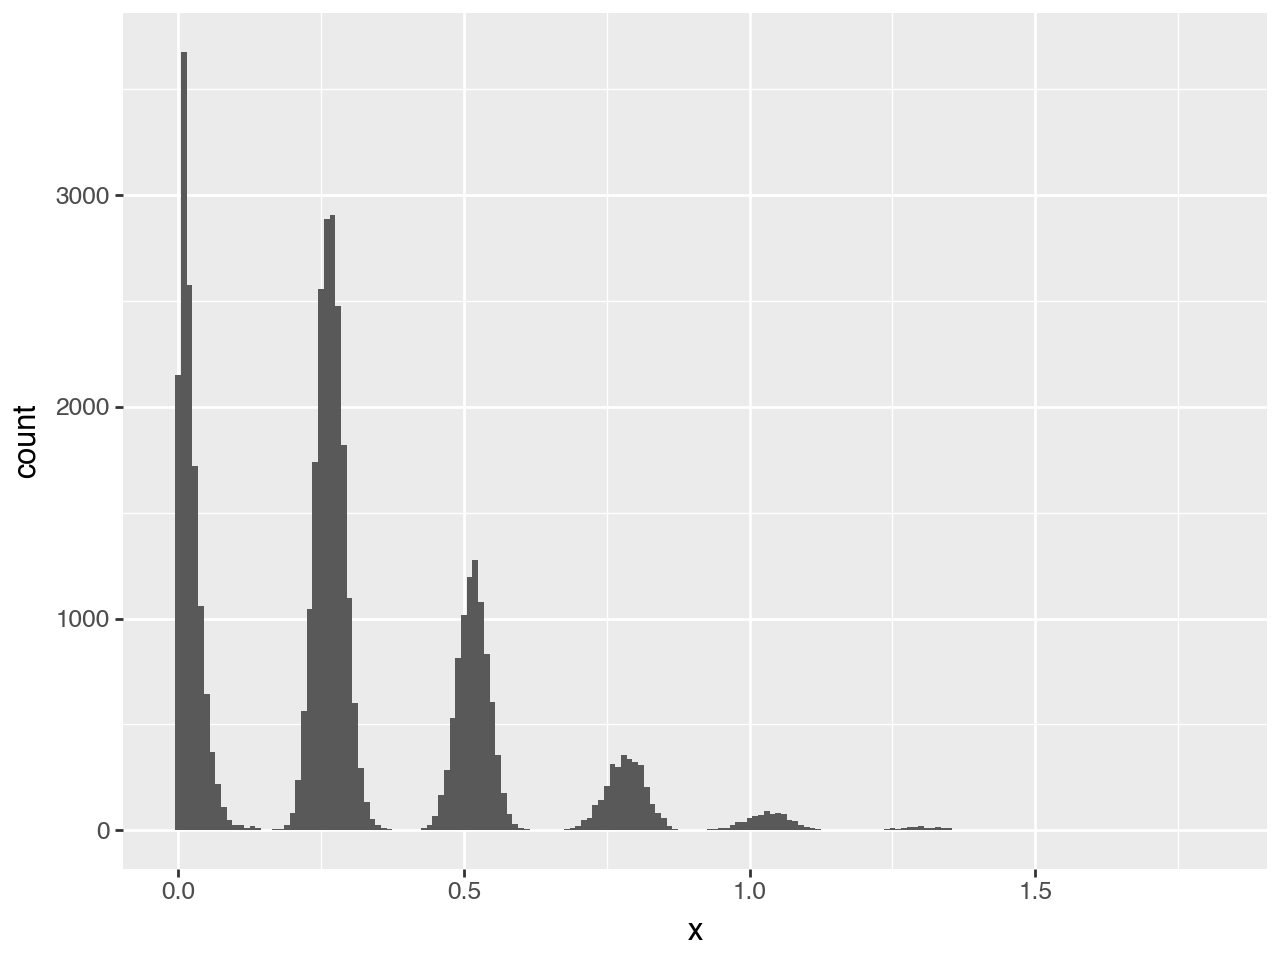

In [361]:
df = pl.DataFrame({'x': l1_outs[l1_outs[:, col_idx] > 0, col_idx].numpy()})
ggplot(df, aes(x='x')) + geom_histogram(binwidth=0.01)